# MNIST handwritten digits classification

In this notebook, we'll train a multi-layer perceptron model to classify MNIST digits using **PyTorch**. 

First, the needed imports. 

In [2]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt

cuda = torch.cuda.is_available()
print('Using PyTorch version:', torch.__version__, 'CUDA:', cuda)

#torch.manual_seed(42)
#if cuda:
#    torch.cuda.manual_seed(42)

Using PyTorch version: 1.5.1+cu101 CUDA: True


## Data

Next we'll load the MNIST data.  First time we may have to download the data, which can take a while.

Note that we are here using the MNIST test data for *validation*, instead of for testing the final model.

In [ ]:
batch_size = 32

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True, **kwargs)

validation_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=False, **kwargs)

The train and test data are provided via data loaders that provide iterators over the datasets. The first element of training data (`X_train`) is a 4th-order tensor of size (`batch_size`, 1, 28, 28), i.e. it consists of a batch of images of size 1x28x28 pixels. `y_train` is a vector containing the correct classes ("0", "1", ..., "9") for each training digit.

In [ ]:
for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break



X_train: torch.Size([32, 1, 28, 28]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


Here are the first 10 training digits:

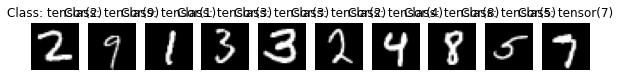

In [ ]:
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(X_train[i,:,:,:].numpy().reshape(28,28), cmap="gray")
    plt.title('Class: '+str(y_train[i]))

## MLP network definition

Let's define the network as a Python class.  We have to write the `__init__()` and `forward()` methods, and PyTorch will automatically generate a `backward()` method for computing the gradients for the backward pass.

Finally, we define an optimizer to update the model parameters based on the computed gradients.  We select *stochastic gradient descent (with momentum)* as the optimization algorithm, and set *learning rate* to 0.01.  Note that there are [several different options](http://pytorch.org/docs/optim.html#algorithms) for the optimizer in PyTorch that we could use instead of *SGD*.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 50)
        self.fc1_drop = nn.Dropout(0.2)
        self.fc2 = nn.Linear(50, 50)
        self.fc2_drop = nn.Dropout(0.2)
        self.fc3 = nn.Linear(50, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = self.fc1_drop(x)
        x = F.relu(self.fc2(x))
        x = self.fc2_drop(x)
        return F.log_softmax(self.fc3(x))

model = Net()
if cuda:
    model.cuda()
    
optimizer = optim.SGD(model.parameters(), lr=0.01)

print(model)

## Learning with Multi-layer perceptron

Let's now define functions to `train()` and `test()` the model. 

In [ ]:
def train(epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def validate(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        val_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

Now we are ready to train our model using the `train()` function.  An *epoch* means one pass through the whole training data. After each epoch, we evaluate the model using `test()`. 

In [ ]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train(epoch)
    validate(lossv, accv)

Let's now visualize how the training progressed. 

* *Loss* is a function of the difference of the network output and the target values.  We are minimizing the loss function during training so it should decrease over time.
* *Accuracy* is the classification accuracy for the test data.

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

##  Lab 1-1 / Learing with simple CNN 
### Make a model in ppt slide

In [4]:
class SimpleCNN(nn.Module):
    """ConvNet -> Max_Pool -> RELU -> ConvNet -> Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = NotImplemented
        self.maxpool1 = NotImplemented
        self.conv2 = NotImplemented
        self.maxpool2 = NotImplemented
        self.conv3 = NotImplemented
        self.fc1 = NotImplemented
        self.fc2 = NotImplemented

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)
        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)
        x = F.relu(self.conv3(x))
        x = x.view(-1, 3*3*20)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [ ]:
model = SimpleCNN()
if cuda:
    model.cuda()
    
optimizer = optim.SGD(model.parameters(), lr=0.01)

print(model)

In [ ]:
def train_CNN(epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def validate_CNN(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        val_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [ ]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train_CNN(epoch)
    validate_CNN(lossv, accv)

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(1,epochs+1), accv)
plt.title('validation accuracy');

##  Lab1-2 / Learing with VGG like CNN 
### Let`s make the VGG-like CNN model provided in the ppt slide

In [6]:
class SimpleVGG(nn.Module):
    def __init__(self):
        super(SimpleVGG, self).__init__()
        # Your implementation here
        self.conv1 = NotImplemented
        self.conv2 = NotImplemented
        self.conv3 = NotImplemented
        self.conv4 = NotImplemented
        self.conv5 = NotImplemented
        self.conv6 = NotImplemented
        self.conv7 = NotImplemented
        self.conv8 = NotImplemented
        self.Linear1 = NotImplemented
        self.drop = NotImplemented
        self.Linear2 = NotImplemented
        self.last_linear = NotImplemented
        # end of your implementation
        self.act = nn.ReLU()
        self.maxpool2d = nn.MaxPool2d(2, 2)
       
    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.maxpool2d(x)
        x = self.act(self.conv2(x))
        x = self.maxpool2d(x)
        x = self.act(self.conv4(self.conv3(x)))
        x = self.maxpool2d(x) 
        x = self.act(self.conv6(self.conv5(x)))        
        x = self.maxpool2d(x)
        x = self.act(self.conv8(self.conv7(x)))
        x = self.maxpool2d(x)
        x = x.view(-1, 512)
        # Your implementation here
        return  F.log_softmax(x, dim=1)

In [ ]:
model = SimpleVGG()
if cuda:
    model.cuda()
    
optimizer = optim.SGD(model.parameters(), lr=0.05)

print(model)

In [ ]:
def train_VGG(epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def validate_VGG(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        val_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [ ]:
%%time
epochs = 10

lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train_VGG(epoch)
    validate_VGG(lossv, accv)

##  Lab1-3 / Learing with ResNet like CNN 
### Let`s make the ResNet-like CNN model provided in the ppt slide

### Residual Block 정의하기 

In [ ]:
class residual_block(nn.Module):
    def __init(self):
        super(ResBlock, self).__init__()
    
    def forward(self, x):
        return output


### SimpleResNet model 만들기

In [ ]:
class SimpleResNet(nn.Module):
    def __init__(self):
        super(SimpleResNet, self).__init__()
        # Your implementation here
       
    def forward(self, x):
        # Your implementation here
        return  F.log_softmax(x, dim=1)

In [ ]:
model = SimpleResNet()
if cuda:
    model.cuda()    
optimizer = optim.SGD(model.parameters(), lr=0.05)

In [ ]:
def train_ResNet(epoch, log_interval=100):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def validate_ResNet(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data, target in validation_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        val_loss += F.nll_loss(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(validation_loader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct / len(validation_loader.dataset)
    accuracy_vector.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(validation_loader.dataset), accuracy))

In [ ]:
%%time
epochs = 10
lossv, accv = [], []
for epoch in range(1, epochs + 1):
    train_ResNet(epoch)
    validate_ResNet(lossv, accv)